In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
# ! pip install seaborn==0.12.2

In [2]:
conn = psycopg2.connect(database="vgp",
                        host="redlab-integration.neuroo.ai",
                        user="SA",
                        password="4xMp6PzEBf6YhJ7P",
                        port="8105")
cur = conn.cursor()
query = "SELECT * FROM metric_city WHERE category = 'JAM_LENGTH'"
raw_data = pd.read_sql_query(query, conn)

conn.close()

C:\Users\doros\AppData\Local\Temp\ipykernel_217556\1930011936.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql_query(query, conn)


In [3]:
raw_data

,id,category,date_event,date_last_update,source,type,value,city_id
0,1232,JAM_LENGTH,2023-06-05 06:45:02,2023-07-11 16:57:28,waze,HEAVY,0.129126,3
1,1233,JAM_LENGTH,2023-06-23 12:17:14,2023-07-11 16:57:28,waze,HEAVY,0.132907,2
2,1234,JAM_LENGTH,2023-06-30 02:46:47,2023-07-11 16:57:28,waze,HEAVY,0.126696,3
3,6,JAM_LENGTH,2023-06-05 06:45:02,2023-07-11 13:27:18,waze,HEAVY,0.129126,3
4,7,JAM_LENGTH,2023-06-23 12:17:14,2023-07-11 13:27:18,waze,HEAVY,0.132907,2
...,...,...,...,...,...,...,...,...
58751,77429,JAM_LENGTH,2023-07-25 15:52:54,2023-07-25 16:15:00,waze,MODERATE,0.561016,2
58752,77430,JAM_LENGTH,2023-07-25 15:59:25,2023-07-25 16:15:00,waze,MODERATE,0.301226,1
58753,77431,JAM_LENGTH,2023-07-25 15:59:26,2023-07-25 16:15:00,waze,MODERATE,0.378487,1
58754,77432,JAM_LENGTH,2023-07-25 16:09:45,2023-07-25 16:15:00,waze,MODERATE,0.303189,3


In [4]:
## delete non-used cols
data = raw_data.copy()
data.drop(columns=['id', 'category', 'date_last_update', 'source'], inplace=True)

data = data[data['city_id']==1] ###########################
data

,date_event,type,value,city_id
6,2023-07-04 22:12:37,HEAVY,0.020354,1
7,2023-07-04 22:12:39,HEAVY,0.105000,1
8,2023-07-07 09:14:57,HEAVY,0.151063,1
11,2023-07-10 06:38:05,HEAVY,0.151063,1
12,2023-07-10 12:25:05,HEAVY,0.020354,1
...,...,...,...,...
58747,2023-07-24 05:39:27,LIGHT,0.308120,1
58750,2023-07-24 05:40:02,MODERATE,0.238860,1
58752,2023-07-25 15:59:25,MODERATE,0.301226,1
58753,2023-07-25 15:59:26,MODERATE,0.378487,1


In [5]:
print(np.unique(data.type))
print(np.unique(data.city_id))

data = data.drop_duplicates()
data = data.sort_values(by='date_event')
data

['HEAVY' 'LIGHT' 'MODERATE']
[1]


,date_event,type,value,city_id
6,2023-07-04 22:12:37,HEAVY,0.020354,1
7,2023-07-04 22:12:39,HEAVY,0.105000,1
8,2023-07-07 09:14:57,HEAVY,0.151063,1
11,2023-07-10 06:38:05,HEAVY,0.151063,1
12,2023-07-10 12:25:05,HEAVY,0.020354,1
...,...,...,...,...
56138,2023-07-26 06:33:53,HEAVY,0.253121,1
56146,2023-07-26 06:44:22,MODERATE,0.274233,1
39441,2023-07-26 07:02:49,HEAVY,0.378487,1
39453,2023-07-26 07:02:53,MODERATE,0.528919,1


# Compute Time delta

In [6]:
# 将 'timestamp' 列转换为 datetime64 格式
data['timestamp'] = pd.to_datetime(data['date_event'])

# 拆分 'timestamp' 列为 'date' 和 'time'
data['date'] = data['timestamp'].dt.date
data['time'] = data['timestamp'].dt.time

# 将 'date' 列转换为星期几
data['weekday'] = data['timestamp'].dt.strftime('%A')

data['tdelta'] = data['date_event'].diff()

In [7]:
np.unique(data.date)

array([datetime.date(2023, 7, 4), datetime.date(2023, 7, 7),
       datetime.date(2023, 7, 10), datetime.date(2023, 7, 11),
       datetime.date(2023, 7, 12), datetime.date(2023, 7, 13),
       datetime.date(2023, 7, 14), datetime.date(2023, 7, 17),
       datetime.date(2023, 7, 18), datetime.date(2023, 7, 19),
       datetime.date(2023, 7, 20), datetime.date(2023, 7, 21),
       datetime.date(2023, 7, 22), datetime.date(2023, 7, 23),
       datetime.date(2023, 7, 24), datetime.date(2023, 7, 25),
       datetime.date(2023, 7, 26)], dtype=object)

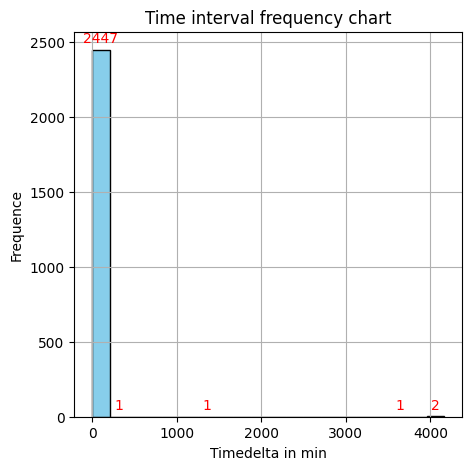

In [8]:
# 绘制频率图
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(data['tdelta'].dropna().dt.total_seconds()/60, bins=20, color='skyblue', edgecolor='black')  # 以min为单位绘制直方图
plt.title('Time interval frequency chart')
plt.xlabel('Timedelta in min')
plt.ylabel('Frequence')
plt.grid(True)

# 在每个柱子上显示频率数值
for i in range(len(patches)):
    if int(n[i]) != 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height() +30,
                 f'{int(n[i])}', ha='center', va='bottom', c='red')

plt.show()

## Filter abnormal time delta

In [10]:
# 将时间间隔转换为分钟
data['tdelta_min'] = data['tdelta'].dt.total_seconds() / 60

# 定义时间间隔阈值，假设你希望排除大于100的时间间隔值
threshold = 12*60

# 根据阈值筛选数据
filtered_data = data[data['tdelta_min'] <= threshold]
filtered_data

,date_event,type,value,city_id,timestamp,date,time,weekday,tdelta,tdelta_min
7,2023-07-04 22:12:39,HEAVY,0.105000,1,2023-07-04 22:12:39,2023-07-04,22:12:39,Tuesday,0 days 00:00:02,0.033333
12,2023-07-10 12:25:05,HEAVY,0.020354,1,2023-07-10 12:25:05,2023-07-10,12:25:05,Monday,0 days 05:47:00,347.000000
13,2023-07-10 15:17:35,HEAVY,0.105000,1,2023-07-10 15:17:35,2023-07-10,15:17:35,Monday,0 days 02:52:30,172.500000
49,2023-07-11 13:33:18,HEAVY,0.188460,1,2023-07-11 13:33:18,2023-07-11,13:33:18,Tuesday,0 days 00:14:26,14.433333
82,2023-07-11 13:44:39,LIGHT,0.187114,1,2023-07-11 13:44:39,2023-07-11,13:44:39,Tuesday,0 days 00:11:21,11.350000
...,...,...,...,...,...,...,...,...,...,...
56138,2023-07-26 06:33:53,HEAVY,0.253121,1,2023-07-26 06:33:53,2023-07-26,06:33:53,Wednesday,0 days 00:02:20,2.333333
56146,2023-07-26 06:44:22,MODERATE,0.274233,1,2023-07-26 06:44:22,2023-07-26,06:44:22,Wednesday,0 days 00:10:29,10.483333
39441,2023-07-26 07:02:49,HEAVY,0.378487,1,2023-07-26 07:02:49,2023-07-26,07:02:49,Wednesday,0 days 00:18:27,18.450000
39453,2023-07-26 07:02:53,MODERATE,0.528919,1,2023-07-26 07:02:53,2023-07-26,07:02:53,Wednesday,0 days 00:00:04,0.066667


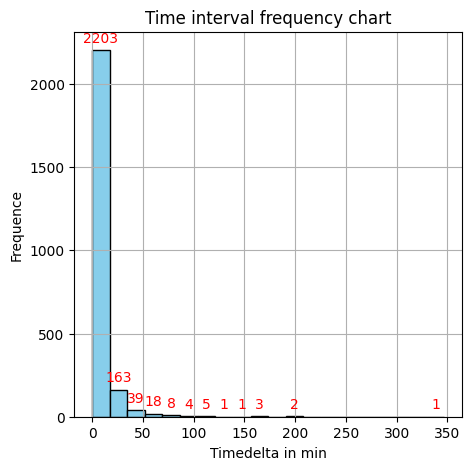

In [11]:
# 绘制频率图
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(filtered_data['tdelta'].dropna().dt.total_seconds()/60, bins=20, color='skyblue', edgecolor='black')  # 以min为单位绘制直方图
plt.title('Time interval frequency chart')
plt.xlabel('Timedelta in min')
plt.ylabel('Frequence')
plt.grid(True)

# 在每个柱子上显示频率数值
for i in range(len(patches)):
    if int(n[i]) != 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height() +30,
                 f'{int(n[i])}', ha='center', va='bottom', c='red')

plt.show()

# Transforme categorical values to numerical values

In [67]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 7 to 39445
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   date_event  2448 non-null   datetime64[ns] 
 1   type        2448 non-null   object         
 2   value       2448 non-null   float64        
 3   city_id     2448 non-null   int64          
 4   timestamp   2448 non-null   datetime64[ns] 
 5   date        2448 non-null   object         
 6   time        2448 non-null   object         
 7   weekday     2448 non-null   object         
 8   tdelta      2448 non-null   timedelta64[ns]
 9   tdelta_min  2448 non-null   float64        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4), timedelta64[ns](1)
memory usage: 210.4+ KB


In [68]:
## numerical coding for "type"

# 使用replace()函数进行替换
filtered_data['type'] = filtered_data['type'].replace({'HEAVY': 0, 'LIGHT': 1, 'MODERATE': 2})
filtered_data['weekday'] = filtered_data['weekday'].replace({
                                                    'Monday': 1,
                                                    'Tuesday': 2,
                                                    'Wednesday': 3,
                                                    'Thursday': 4,
                                                    'Friday': 5,
                                                    'Saturday': 6,
                                                    'Sunday': 7
})

filtered_data


## one-hot coding for "type" and "city_id"
# new_df = pd.get_dummies(data, columns=['type'], dtype=int)
# new_df = pd.get_dummies(new_df, columns=['city_id'], dtype=int)
# new_df

C:\Users\doros\AppData\Local\Temp\ipykernel_218664\3305235726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['type'] = filtered_data['type'].replace({'HEAVY': 0, 'LIGHT': 1, 'MODERATE': 2})
C:\Users\doros\AppData\Local\Temp\ipykernel_218664\3305235726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['weekday'] = filtered_data['weekday'].replace({


,date_event,type,value,city_id,timestamp,date,time,weekday,tdelta,tdelta_min
7,2023-07-04 22:12:39,0,0.105000,1,2023-07-04 22:12:39,2023-07-04,22:12:39,2,0 days 00:00:02,0.033333
12,2023-07-10 12:25:05,0,0.020354,1,2023-07-10 12:25:05,2023-07-10,12:25:05,1,0 days 05:47:00,347.000000
13,2023-07-10 15:17:35,0,0.105000,1,2023-07-10 15:17:35,2023-07-10,15:17:35,1,0 days 02:52:30,172.500000
49,2023-07-11 13:33:18,0,0.188460,1,2023-07-11 13:33:18,2023-07-11,13:33:18,2,0 days 00:14:26,14.433333
82,2023-07-11 13:44:39,1,0.187114,1,2023-07-11 13:44:39,2023-07-11,13:44:39,2,0 days 00:11:21,11.350000
...,...,...,...,...,...,...,...,...,...,...
56138,2023-07-26 06:33:53,0,0.253121,1,2023-07-26 06:33:53,2023-07-26,06:33:53,3,0 days 00:02:20,2.333333
56146,2023-07-26 06:44:22,2,0.274233,1,2023-07-26 06:44:22,2023-07-26,06:44:22,3,0 days 00:10:29,10.483333
39441,2023-07-26 07:02:49,0,0.378487,1,2023-07-26 07:02:49,2023-07-26,07:02:49,3,0 days 00:18:27,18.450000
39453,2023-07-26 07:02:53,2,0.528919,1,2023-07-26 07:02:53,2023-07-26,07:02:53,3,0 days 00:00:04,0.066667


In [69]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 7 to 39445
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   date_event  2448 non-null   datetime64[ns] 
 1   type        2448 non-null   int64          
 2   value       2448 non-null   float64        
 3   city_id     2448 non-null   int64          
 4   timestamp   2448 non-null   datetime64[ns] 
 5   date        2448 non-null   object         
 6   time        2448 non-null   object         
 7   weekday     2448 non-null   int64          
 8   tdelta      2448 non-null   timedelta64[ns]
 9   tdelta_min  2448 non-null   float64        
dtypes: datetime64[ns](2), float64(2), int64(3), object(2), timedelta64[ns](1)
memory usage: 210.4+ KB


In [70]:
filtered_data.to_csv('filtered_data_city1.csv', sep='\t', index=False)

## Type Frequency

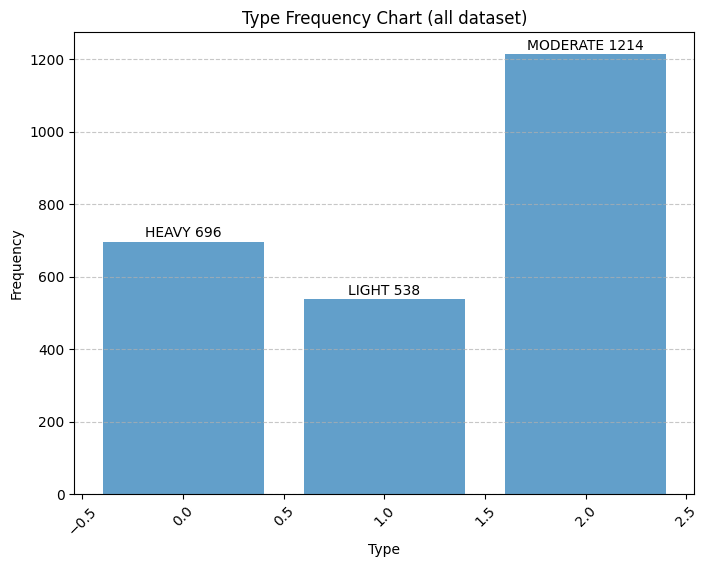

In [71]:
# 统计各种类型的频数
type_counts = filtered_data['type'].value_counts().sort_index()

# 绘制拥堵类型的直方图
plt.figure(figsize=(8, 6))
plt.bar(type_counts.index, type_counts.values, alpha=0.7)

# 添加标签和频数标注
dic = {0:'HEAVY', 1:'LIGHT', 2: 'MODERATE'}

for i, v in enumerate(type_counts.values[::]):
    plt.text(i, v+5, dic[i]+' '+str(v), ha='center', va='bottom', fontsize=10)

plt.title('Type Frequency Chart (all dataset)')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [47]:
for i in type_counts.sort_values():
    print(i)

538
696
1214


In [32]:
daily_counts

type,0,1,2
weekday,,,
0,275,312,499
1,413,480,848
2,409,540,875
3,401,466,769
4,175,239,380
5,104,184,256
6,407,150,333


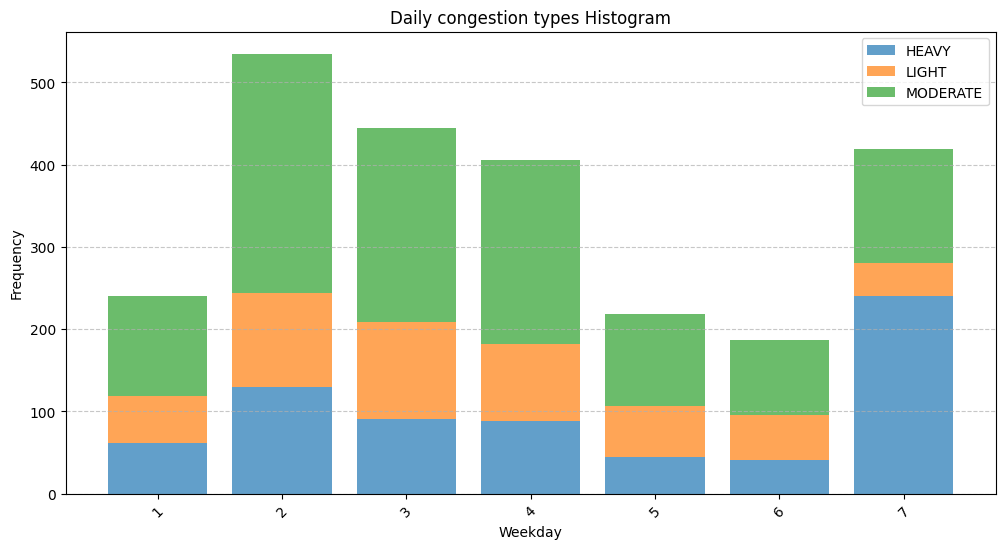

In [72]:
# 统计每天各种类型的频数
daily_counts = filtered_data.groupby([filtered_data['weekday'], 'type']).size().unstack(fill_value=0)

# 绘制每天拥堵类型的直方图
plt.figure(figsize=(12, 6))

# for type_value in daily_counts.columns:
#     plt.bar(daily_counts.index, daily_counts[type_value], alpha=0.7, label=type_value)

# 绘制堆叠的柱状图
p1 = plt.bar(daily_counts.index, daily_counts[0], alpha=0.7, label='HEAVY')
p2 = plt.bar(daily_counts.index, daily_counts[1], bottom=daily_counts[0], alpha=0.7, label='LIGHT')
p3 = plt.bar(daily_counts.index, daily_counts[2], bottom=daily_counts[0] + daily_counts[1], alpha=0.7, label='MODERATE')

plt.title('Daily congestion types Histogram')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

## Value-type correlation

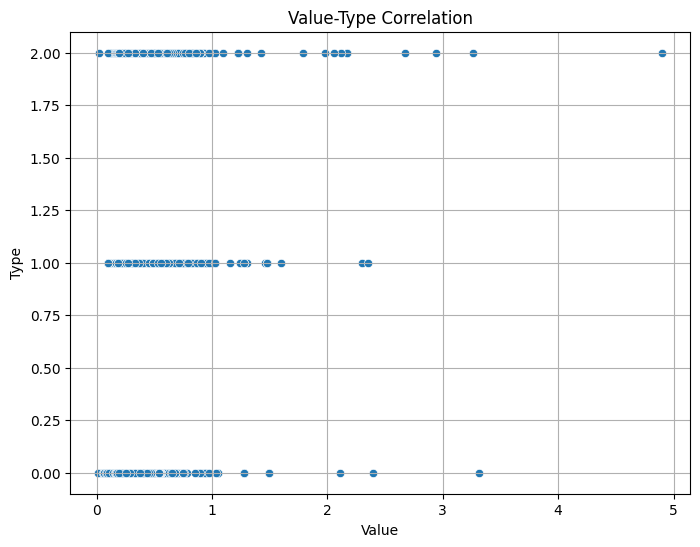

In [54]:
# 计算相关系数
value_type_corr = filtered_data['value'].corr(filtered_data['type'])

# 绘制相关度图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='value', y='type', data=filtered_data)
plt.title('Value-Type Correlation')
plt.xlabel('Value')
plt.ylabel('Type')
# plt.text(filtered_data['value'].min(), filtered_data['type'].max(), f'Correlation: {value_type_corr:.2f}', fontsize=12, color='red')
plt.grid(True)
plt.show()

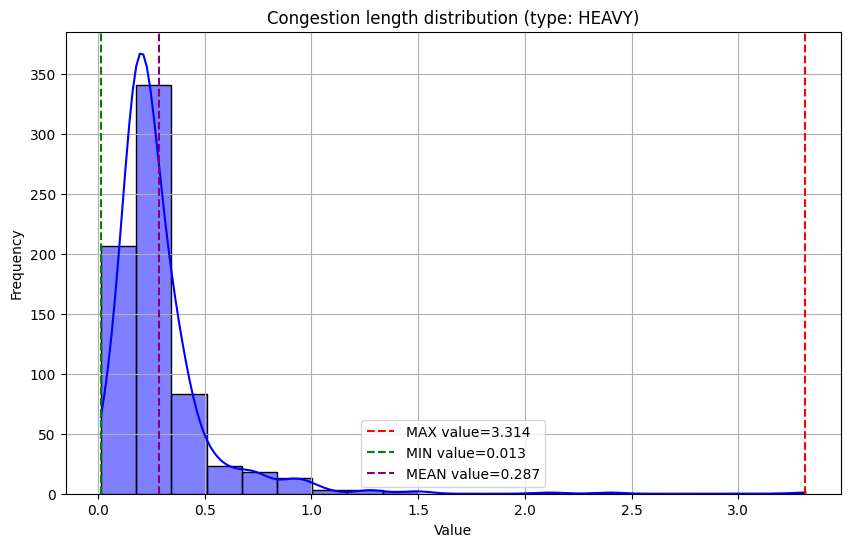

In [55]:
# 提取特定类型的数据
heavy_data = filtered_data[filtered_data['type'] == 0]  # 替换为 '0' 如果 type 是数值型

# 计算统计值
max_value = heavy_data['value'].max()
min_value = heavy_data['value'].min()
mean_value = heavy_data['value'].mean()

# 绘制拥堵长度分布图
plt.figure(figsize=(10, 6))
sns.histplot(data=heavy_data, x='value', bins=20, kde=True, color='blue')

plt.axvline(x=max_value, color='red', linestyle='--', label='MAX value=%.3f'%max_value)
plt.axvline(x=min_value, color='green', linestyle='--', label='MIN value=%.3f'%min_value)
plt.axvline(x=mean_value, color='purple', linestyle='--', label='MEAN value=%.3f'%mean_value)

plt.title('Congestion length distribution (type: HEAVY)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
        
plt.show()

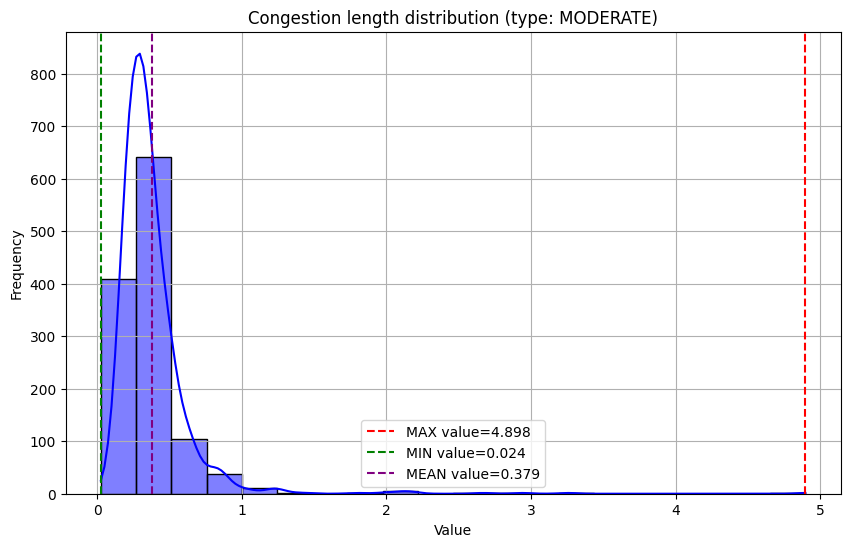

In [56]:
# 提取特定类型的数据
moderate_data = filtered_data[filtered_data['type'] == 2] 

# 计算统计值
max_value = moderate_data['value'].max()
min_value = moderate_data['value'].min()
mean_value = moderate_data['value'].mean()

# 绘制拥堵长度分布图
plt.figure(figsize=(10, 6))
sns.histplot(data=moderate_data, x='value', bins=20, kde=True, color='blue')

plt.axvline(x=max_value, color='red', linestyle='--', label='MAX value=%.3f'%max_value)
plt.axvline(x=min_value, color='green', linestyle='--', label='MIN value=%.3f'%min_value)
plt.axvline(x=mean_value, color='purple', linestyle='--', label='MEAN value=%.3f'%mean_value)

plt.title('Congestion length distribution (type: MODERATE)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
        
plt.show()

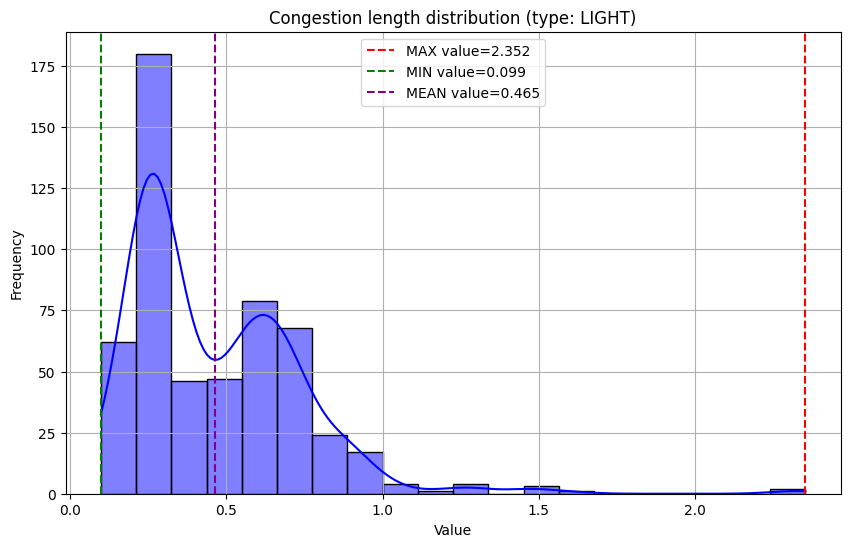

In [57]:
# 提取特定类型的数据
light_data = filtered_data[filtered_data['type'] == 1] 

# 计算统计值
max_value = light_data['value'].max()
min_value = light_data['value'].min()
mean_value = light_data['value'].mean()

# 绘制拥堵长度分布图
plt.figure(figsize=(10, 6))
sns.histplot(data=light_data, x='value', bins=20, kde=True, color='blue')

plt.axvline(x=max_value, color='red', linestyle='--', label='MAX value=%.3f'%max_value)
plt.axvline(x=min_value, color='green', linestyle='--', label='MIN value=%.3f'%min_value)
plt.axvline(x=mean_value, color='purple', linestyle='--', label='MEAN value=%.3f'%mean_value)

plt.title('Congestion length distribution (type: LIGHT)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
        
plt.show()

## EDA

In [ ]:


# 绘制不同时间段的拥堵情况图
plt.figure(figsize=(10, 6))
plt.plot(selected_df['timestamp'], selected_df['拥堵长度'], marker='o', label='拥堵长度')
plt.plot(selected_df['timestamp'], selected_df['拥堵程度'].map({'HEAVY': 2, 'MODERATE': 1, 'LIGHT': 0}), marker='o', label='拥堵程度')
plt.xlabel('时间')
plt.ylabel('值')
plt.title(f'{selected_date} 道路拥堵情况')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
selected_df.sort_values(by='time')

,date_event,value,type_HEAVY,type_LIGHT,type_MODERATE,city_id_1,city_id_2,city_id_3,timestamp,date,time,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
58278,2023-07-24 00:07:28,0.395160,0,1,0,0,1,0,2023-07-24 00:07:28,2023-07-24,00:07:28,0,1,0,0,0,0,0
58285,2023-07-24 00:07:28,0.395160,0,1,0,0,1,0,2023-07-24 00:07:28,2023-07-24,00:07:28,0,1,0,0,0,0,0
58279,2023-07-24 00:08:49,0.644763,0,1,0,0,1,0,2023-07-24 00:08:49,2023-07-24,00:08:49,0,1,0,0,0,0,0
58286,2023-07-24 00:08:49,0.644763,0,1,0,0,1,0,2023-07-24 00:08:49,2023-07-24,00:08:49,0,1,0,0,0,0,0
58298,2023-07-24 00:15:34,0.209749,1,0,0,0,0,1,2023-07-24 00:15:34,2023-07-24,00:15:34,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48193,2023-07-24 23:38:40,0.219691,1,0,0,0,0,1,2023-07-24 23:38:40,2023-07-24,23:38:40,0,1,0,0,0,0,0
48209,2023-07-24 23:51:32,0.208866,0,0,1,0,1,0,2023-07-24 23:51:32,2023-07-24,23:51:32,0,1,0,0,0,0,0
48324,2023-07-24 23:51:32,0.208866,0,0,1,0,1,0,2023-07-24 23:51:32,2023-07-24,23:51:32,0,1,0,0,0,0,0
48210,2023-07-24 23:55:45,0.112506,0,0,1,1,0,0,2023-07-24 23:55:45,2023-07-24,23:55:45,0,1,0,0,0,0,0


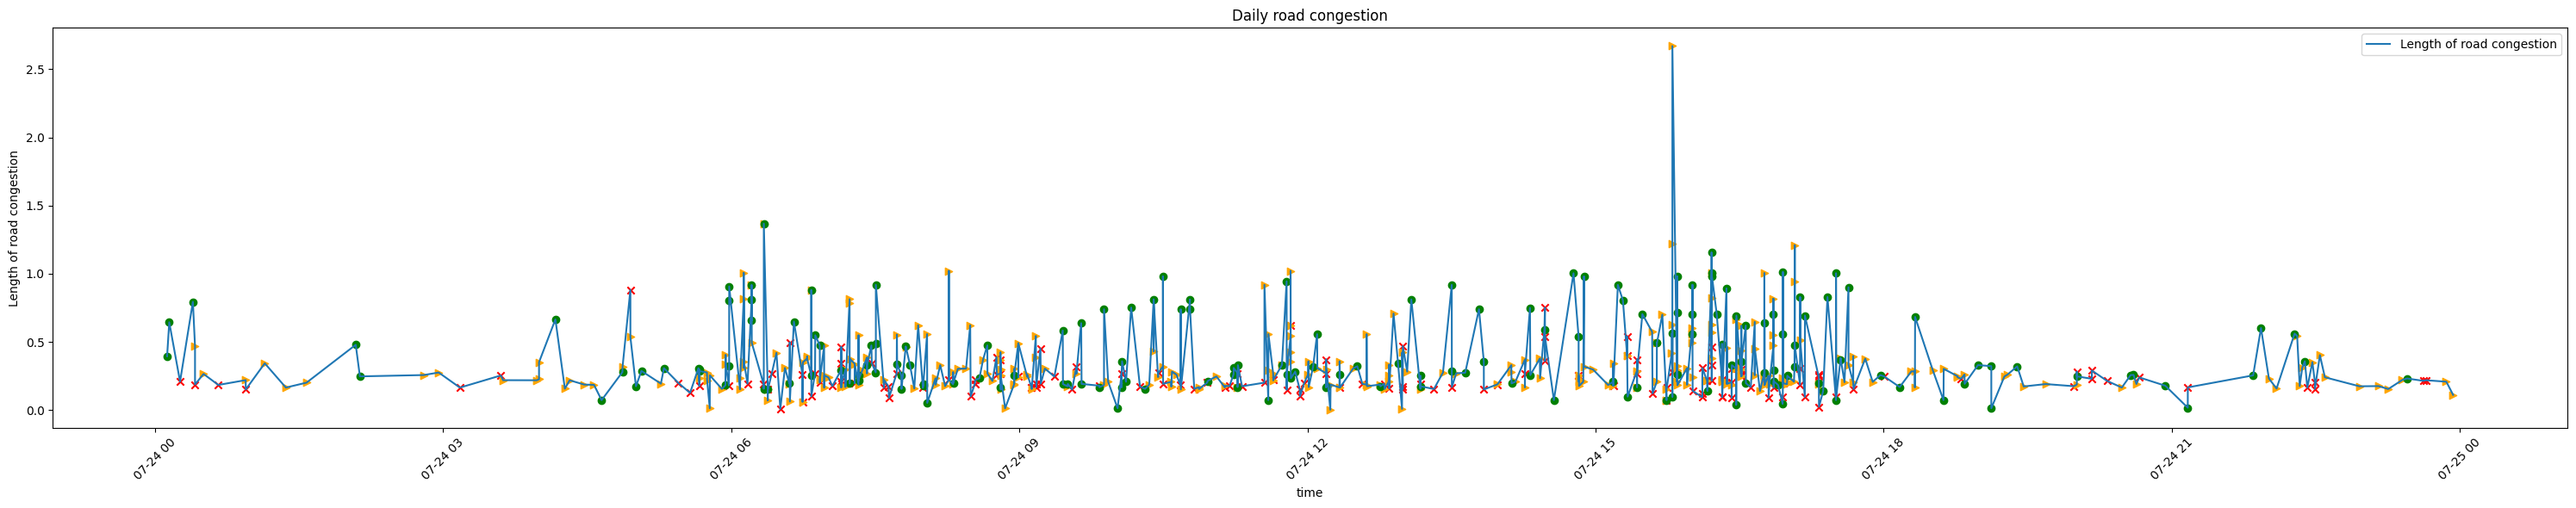

In [51]:
# 设置颜色映射和符号
colors = {'HEAVY': 'red', 'MODERATE': 'orange', 'LIGHT': 'green'}
markers = {'HEAVY': 'x', 'MODERATE': '>', 'LIGHT': 'o'}

# 绘制每天的拥堵长度图
plt.figure(figsize=(30, 6))

# for date in new_df['date'].unique():
#     subset = new_df[new_df['date'] == date]

# 筛选某一天的数据（示例中选择 2023-08-09）
selected_date = datetime.date(2023, 7, 24)
subset = new_df_no_duplicates[new_df_no_duplicates['date'] == selected_date]
subset = subset.sort_values(by='time')

for level in ['HEAVY', 'MODERATE', 'LIGHT']:
    sub_subset = subset[subset[f'type_{level}'] == 1]
    plt.scatter(sub_subset['timestamp'], sub_subset['value'], c=colors[level], marker=markers[level])
plt.plot(selected_df['timestamp'], selected_df['value'], label='Length of road congestion')   
    
plt.xlabel('time')
plt.ylabel('Length of road congestion')
plt.title('Daily road congestion')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

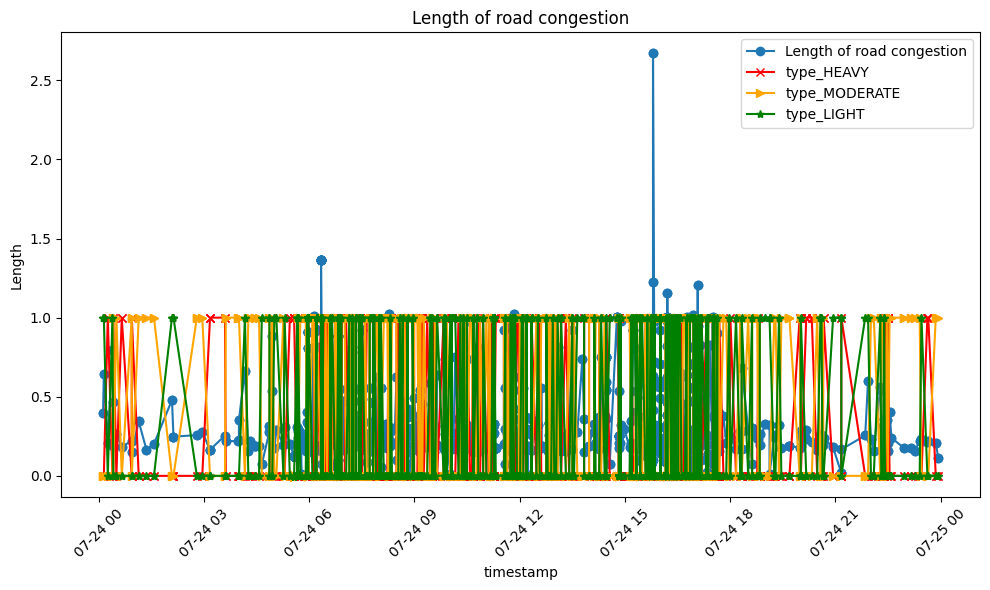

In [38]:
# 筛选某一天的数据（示例中选择 2023-08-09）
selected_date = datetime.date(2023, 7, 24)
selected_df = new_df[new_df['date'] == selected_date]
selected_df = selected_df.sort_values(by='time')

# 绘制时间序列图
plt.figure(figsize=(10, 6))

# # 设置不同拥堵程度的颜色和符号
# colors = {'HEAVY': 'red', 'MODERATE': 'orange', 'LIGHT': 'green'}
# markers = {'HEAVY': 'o', 'MODERATE': 's', 'LIGHT': '^'}

plt.plot(selected_df['timestamp'], selected_df['value'], marker='o', label='Length of road congestion')
plt.plot(selected_df['timestamp'], selected_df['type_HEAVY'], marker='x', color='red', label='type_HEAVY')
plt.plot(selected_df['timestamp'], selected_df['type_MODERATE'], marker='>', color='orange', label='type_MODERATE')
plt.plot(selected_df['timestamp'], selected_df['type_LIGHT'], marker='*', color='green', label='type_LIGHT')


plt.xlabel('timestamp')
plt.ylabel('Length')
plt.title('Length of road congestion')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()